In [1]:
from deeppavlov.models.bidirectional_lms import elmo_bilm
from deeppavlov.models.tokenizers.lazy_tokenizer import LazyTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import numpy as np
from typing import List
from scipy.stats import kurtosis
from scipy.stats.mstats import gmean
import pandas as pd

[nltk_data] Downloading package punkt to /home/sultanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import re
replacement_patterns = [
     (r'won\'t', 'will not'),
     (r'can\'t', 'cannot'),
     (r'i\'m', 'i am'),
     (r'ain\'t', 'is not'),
     (r'(\w+)\'ll', '\g<1> will'),
     (r'(\w+)n\'t', '\g<1> not'),
     (r'(\w+)\'ve', '\g<1> have'),
     (r'(\w+)\'s', '\g<1> is'),
     (r'(\w+)\'re', '\g<1> are'),
     (r'(\w+)\'d', '\g<1> would')
]
class RegexpReplacer():
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)
        return s

In [3]:
class ElmoAug:
    
    def __init__(self, model_dir="/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news"):
        self.tokenizer = LazyTokenizer()
        self.elmo_lm   = elmo_bilm.ELMoEmbedder(model_dir=model_dir)
        self.detokenizer = MosesDetokenizer()
        self.tmp_logger = []
        self.logger = []
        self.num_sent = 0
        self.replacer = RegexpReplacer()
        
    def _multi_argmax(self, values: np.ndarray, n_instances: int = 1) -> np.ndarray:
        """
        Selects the indices of the n_instances highest values.
        Args:
            values: Contains the values to be selected from.
            n_instances: Specifies how many indices to return.
        Returns:
            Contains the indices of the n_instances largest values.
        """
        assert n_instances <= values.shape[0], 'n_instances must be less or equal than the size of utility'

        max_idx = np.argpartition(-values, n_instances-1, axis=0)[:n_instances]
        return max_idx
    
    def _weighted_sum_distr_by_posistion_in_sent(self, distr):
        if len(distr) > 4:
            weights = np.array([0.2, 0.35] + [0.5]*(len(distr) - 4) + [0.65, 0.8])
        else:
            weights = 0.5*np.ones(len(distr))
        left = distr[:,0,:]
        right = distr[:,1,:]
        right = right.transpose([1, 0]) * (1-weights)
        right = right.transpose([1, 0])
        left = left.transpose([1, 0]) * weights
        left = left.transpose([1, 0])
        return right + left

    def _blend_dist(self, batch_distr, num_method):
        """
        blending distr from left and right context
        method 0:
            sum two distr along left right context
        method 1:
            weighted sum by place of word in sentence
        """
        if num_method == 0:
            return [np.sum(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 1:
            return [self._weighted_sum_distr_by_posistion_in_sent(distr) for distr in batch_distr]
        
        elif num_method == 2:
            return [np.min(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 3:
            return [gmean(distr, axis=1) for distr in batch_distr]
    
    def _softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def _sample_distr(self, distr):
        """Sampling from given distribution"""
        threshold = np.random.random_sample()
        i = 0
        while threshold - distr[i] > 0:
            threshold -= distr[i]
            i += 1
        return i
    
    def _sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                indexs = self._multi_argmax(distr[i], n_top_words)
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]    
                p = self._softmax([distr[i, index] for index in self._multi_argmax(distr[i], n_top_words)])
                word = words[self._sample_distr(p)]
                result.append(word)
                for n, w in enumerate(words):
                    self.tmp_logger.append({'num_sent': self.num_sent, 'num_token_in_sent': i, 'source_token': token, 'replacement': w, 'agr_distr': distr[i, indexs[n]], 'idx_voc': indexs[n]})#+
            else:
                result.append(token)
        self.num_sent += 1
        return result

    
    def _batch_sent(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int) -> List[str]:
        """
        Replaces some words in the original sentence with words from the language model with frequency p
        Args:
            batch_token: Sentences to be augmented 
            n_top_words: The number of the most likely words from the language model that will be considered as a replacement for the original.
            p: frequency of replacing words
        Returns:
            Contains the augmented sentences
        """
        batch_sent = [self.replacer.replace(sent) for sent in batch_sent]
        batch_token    = self.tokenizer(batch_sent)
        self.left_right_batch_token = self.elmo_lm(batch_token)
        batch_distr = self._blend_dist(self.left_right_batch_token, num_method_blend)
        batch_aug_token = [self._sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        for row in self.tmp_logger:
            row.update({"left_distr": self.left_right_batch_token[row['num_sent']][row['num_token_in_sent'], 0, row['idx_voc']], "right_distr": self.left_right_batch_token[row['num_sent']][row['num_token_in_sent'], 1, row['idx_voc']]})
        return batch_aug_token        
    
    def __call__(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int):
        batch_aug_token = self._batch_sent(batch_sent, n_top_words, replace_freq, num_method_blend)
        return [self.detokenizer.detokenize(i, return_str=True) for i in batch_aug_token]

In [4]:
el = ElmoAug()

Using TensorFlow backend.


****************************************************************************************************
/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news
Instructions for updating:
Use the `axis` argument instead


2018-10-25 16:59:12.988 WARNING in 'tensorflow'['tf_logging'] at line 125: From /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/bilm/training.py:217: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


USING SKIP CONNECTIONS
INFO:tensorflow:Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


2018-10-25 16:59:13.507 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


In [5]:
test_sentences = \
["Almost half of all iPhone owners have broken their screens, not just once but an average of two times each.",\
   "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.",\
   "shut the fuck up. you and the rest of your faggot friends should be burned at the stake",\
   "That you are an idiot who understands neither taxation nor women's health.",\
   "What on Earth is that about? Is it what's going to get him fired eventually?",\
   "This is a doctrine of constitutional interpretation that says that a constitution is organic and must be read in a broad and liberal manner so as to adapt it to changing times.",\
   "In the 2000s, music notation typically means the written expression of music notes and rhythms on paper using symbols.",\
   "Most of the mathematical notation in use today was not invented until the 16th century.[52] Before that, mathematics was written out in words, limiting mathematical discovery.",\
   "Physical geography deals with the study of processes and patterns in the natural environment like the atmosphere, hydrosphere, biosphere, and geosphere.",\
   "An autobiography is written by the person himself or herself, sometimes with the assistance of a collaborator or ghostwriter."]

In [6]:
%%time
el(test_sentences, 10, 1, 3)

CPU times: user 53min 44s, sys: 29min 53s, total: 1h 23min 38s
Wall time: 2min 14s


['About two that US phone, had the a phones on for at for on the all or four at -- "',
 "They think do't understand one question - It means, we like in nuts,) to",
 'The down <UNK> up and </S> think <UNK> "are us closest said must have shot on\'s expense',
 "If is is the American to's about is as life,... or",
 '"about the? it you... Is, something the trying... have be\'s? from',
 'there has the concept to moral doctrine ", of" word or written law cannot be done by that neutral and <UNK>, to the and make it, economic. from',
 'Since and world that the <UNK> which included the same lyrics to "and to is in not as,"',
 'Some but the a theory they the and were the "during late 17th <UNK>;:: <UNK> Before this to word is that" in words at in personal and to',
 '<UNK> "on are more" in animals to trends and a environment environments to natural weather of oceans of water air social the from',
 "an ad were to with the man you to others -- it or her hands, your journalist's the or"]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
?
data_m = pd.DataFrame(el.tmp_logger)
data_m.rename(index=str, columns={"agr_distr": "min"}, inplace=True)

2018-10-25 17:01:30.764 DEBUG in 'matplotlib'['__init__'] at line 415: CACHEDIR=/home/sultanov/.cache/matplotlib
2018-10-25 17:01:30.766 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1359: Using fontManager instance from /home/sultanov/.cache/matplotlib/fontlist-v300.json
2018-10-25 17:01:30.840 DEBUG in 'matplotlib.pyplot'['pyplot'] at line 211: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [8]:
data_m['sum'] = (data_m['left_distr'] + data_m['right_distr'])/2

In [9]:
def show_distr(num_sent=0):
    d = data_m[data_m['num_sent'] == num_sent]
    d = d.sort_values(["num_token_in_sent", "min"])
    print(f"sentence: {test_sentences[num_sent]}")
    return d[['source_token', 'replacement', 'left_distr', "right_distr", 'min', 'sum']]
pd.options.display.max_rows = 999
show_distr(1)

sentence: i really don't understand your point.  It seems that you are mixing apples and oranges.


,source_token,replacement,left_distr,right_distr,min,sum
229,i,they,0.000117,2.117383e-02,0.001572,0.010645
228,i,The,0.146437,1.976802e-05,0.001701,0.073228
227,i,People,0.000711,4.191045e-03,0.001726,0.002451
220,i,and,0.000296,1.248931e-02,0.001921,0.006392
223,i,You,0.001457,8.283848e-03,0.003474,0.004871
224,i,",",0.002674,6.633863e-03,0.004212,0.004654
221,i,They,0.003572,7.929214e-03,0.005322,0.005751
222,i,"""",0.038078,7.967672e-04,0.005508,0.019437
225,i,We,0.004455,8.533123e-03,0.006165,0.006494
226,i,I,0.016421,8.058838e-01,0.115035,0.411152


/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


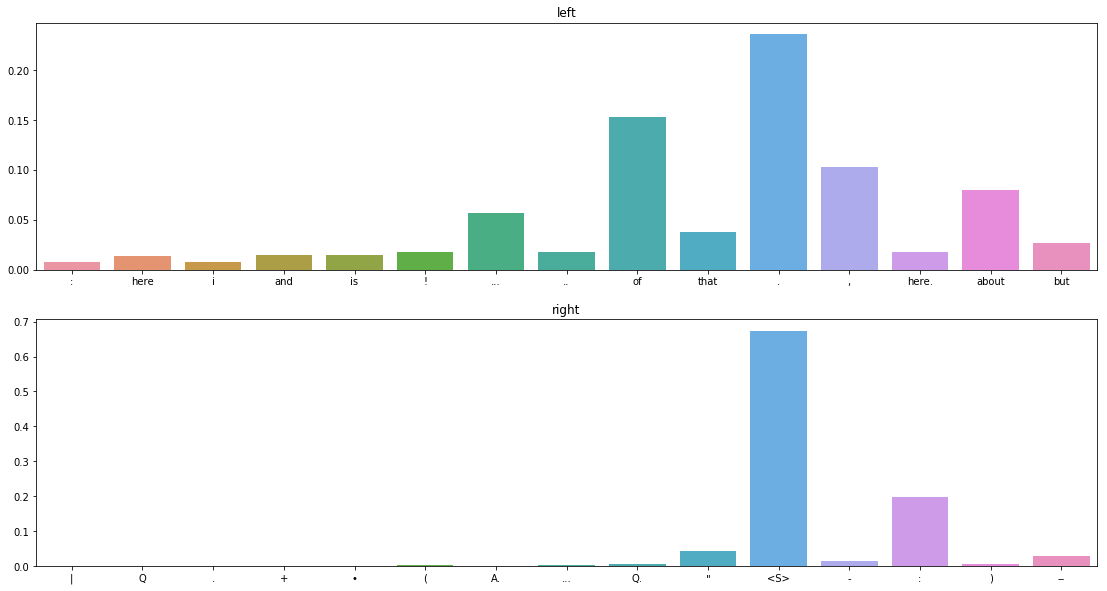

In [10]:
plt.figure(figsize=(19,10))
def show_distr_for_token(num_sent: int, token: str, num_replace_token: int=5):
    row = data_m[(data_m['num_sent'] == num_sent) & (data_m['source_token'] == token)].reset_index(drop=True).loc[0]
    left = el.left_right_batch_token[row['num_sent']][row['num_token_in_sent'], 0,:]
    left_indx = np.argpartition(left, -num_replace_token)[-num_replace_token:]
    right = el.left_right_batch_token[row['num_sent']][row['num_token_in_sent'], 1,:]
    right_indx = np.argpartition(right, -num_replace_token)[-num_replace_token:]
    plt.subplot(2,1,1)
    sns.barplot(x=np.array(el.elmo_lm.get_vocab())[left_indx], y=left[left_indx])
    plt.title('left')
    plt.subplot(2,1,2)
    sns.barplot(x=np.array(el.elmo_lm.get_vocab())[right_indx], y=right[right_indx])
    plt.title('right')
    
    
show_distr_for_token(num_sent = 1,token = '.', num_replace_token = 15)